In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.discrete.discrete_model import Probit, Logit
from scipy import stats

In [22]:
# import manifesto project data, ignore missing values, standardize rile pervote and convert election date
manifesto_df = pd.read_csv("MPDataset_MPDS2019b.csv")
needed_columns = ['edate', 'countryname', 'country', 'pervote', 'rile', 'party', 'partyabbrev']
manifesto_df = manifesto_df.dropna(subset=needed_columns)
manifesto_df["zrile"] = stats.zscore(manifesto_df["rile"])
manifesto_df["pervote"] = manifesto_df["pervote"] / 100
manifesto_df["year"] = pd.to_datetime(manifesto_df["edate"]).dt.year

(array([  13.,  109.,  470., 1056., 1246.,  650.,  296.,   97.,   21.,
           5.]),
 array([-3.2579077 , -2.50260154, -1.74729539, -0.99198923, -0.23668307,
         0.51862309,  1.27392925,  2.02923541,  2.78454156,  3.53984772,
         4.29515388]),
 <a list of 10 Patch objects>)

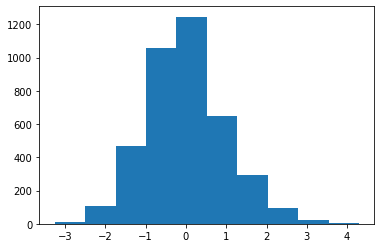

In [9]:
plt.hist(manifesto_df["zrile"])

In [10]:
manifesto_df.describe()

,country,oecdmember,eumember,date,party,parfam,coderid,manual,coderyear,testresult,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,zrile,year
count,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3963.000000,3732.000000,2433.000000,...,448.000000,448.000000,448.000000,3963.00000,3963.000000,3963.000000,3963.000000,3963.000000,3.963000e+03,3963.000000
mean,52.935402,6.230129,5.008832,199010.068635,53422.839011,49.232400,271.057028,199.143073,1998.872186,0.778383,...,0.019022,2.645768,0.056165,-2.61540,3.704854,4.179327,11.784381,2.060020,3.815604e-17,1990.027504
std,34.693311,4.846928,6.021891,1946.853009,34695.595775,38.090977,215.436230,397.140569,12.258430,0.123867,...,0.169403,2.979690,0.402229,22.00604,4.041957,5.487914,7.789519,4.122441,1.000126e+00,19.469374
min,11.000000,0.000000,0.000000,192011.000000,11110.000000,10.000000,101.000000,0.000000,1980.000000,0.341000,...,0.000000,0.000000,0.000000,-74.30000,0.000000,0.000000,0.000000,0.000000,-3.257908e+00,1920.000000
25%,22.000000,0.000000,0.000000,197707.500000,22420.000000,30.000000,113.000000,1.000000,1990.000000,0.720000,...,0.000000,0.551500,0.000000,-17.28500,0.813000,0.594000,6.356000,0.000000,-6.667011e-01,1977.000000
50%,43.000000,10.000000,0.000000,199405.000000,43530.000000,40.000000,233.000000,2.000000,1997.000000,0.797000,...,0.000000,1.822500,0.000000,-3.75300,2.660000,2.400000,10.646000,0.640000,-5.170141e-02,1994.000000
75%,80.000000,10.000000,10.000000,200605.500000,80510.000000,60.000000,291.000000,5.000000,2011.000000,0.849000,...,0.000000,3.916500,0.000000,10.18050,5.259500,5.598000,15.925500,2.300000,5.815456e-01,2006.000000
max,181.000000,10.000000,20.000000,201810.000000,181910.000000,999.000000,999.000000,999.000000,2019.000000,1.000000,...,2.222000,20.455000,4.678000,91.89200,74.300000,68.500000,70.732000,72.222000,4.295154e+00,2018.000000


In [21]:
# generate polarization measures from manifesto data

elections = manifesto_df["year"].unique()

poldata = []

for date in elections:
    election_df = manifesto_df[manifesto_df["year"] == date]
    
    for country in set(election_df.country):
        country_df = election_df[election_df["country"] == country]
        results = list(zip(country_df.partyabbrev, country_df.pervote, country_df.zrile))
        
        winner = max(results, key = lambda x: x[1])
        winner_score = winner[2] # score = rile * pervote
        
        results.remove(winner)
        polarization = (winner_score - sum([x[2] * (x[1] / (1-winner[1])) for x in results])) ** 2
        
        p = {"countryname": list(country_df.countryname)[0], 
             "year": date, 
             "manifesto_polarization": polarization
            }
        
        poldata.append(p)
        
poldf = pd.DataFrame(poldata)
poldf.head()

,countryname,year,manifesto_polarization
0,Sweden,1944,3.380857
1,United States,1944,0.176919
2,Italy,1948,0.622392
3,Sweden,1948,2.783636
4,Finland,1948,0.021968


In [17]:
# get polarization measures from DPI database
dpi = pd.read_stata("DPI2017.dta")
dpi["dpi_polarization"] = dpi["polariz"]
dpi = dpi.drop(dpi.columns.difference(['dpi_polarization','countryname', 'year']), 1)
dpi = dpi.replace(to_replace="NA", value = np.nan)
dpi = dpi.dropna(subset=["dpi_polarization", "countryname", "year"])
dpi["year"] = dpi["year"].dt.year

In [20]:
# Fix the differences between DPI and Manifestos
dpi = dpi.replace(to_replace="Czech Rep.", value = "Czech Republic")
dpi = dpi.replace(to_replace="GDR", value= "German Democratic Republic")
dpi = dpi.replace(to_replace="FRG/Germany", value= "Germany")
dpi = dpi.replace(to_replace="USA", value= "United States")
dpi = dpi.replace(to_replace="UK", value= "United Kingdom")
dpi = dpi.replace(to_replace="Macedonia", value= "North Macedonia")
dpi = dpi.replace(to_replace="Bosnia-Herz", value= "Bosnia-Herzegovina")
dpi = dpi.replace(to_replace="S. Africa", value= "South Africa")
dpi = dpi.replace(to_replace="S. Korea", value= "South Korea")


dpi_country = dpi[dpi["countryname"] == "United States"]
dpi_country.head(10)

,countryname,year,dpi_polarization
7106,United States,1977,0.0
7107,United States,1978,0.0
7108,United States,1979,0.0
7109,United States,1980,0.0
7110,United States,1981,2.0
7111,United States,1982,2.0
7112,United States,1983,2.0
7113,United States,1984,2.0
7114,United States,1985,2.0
7115,United States,1986,2.0


In [25]:
combdf = pd.concat([poldf, dpi], sort=False)
combdf = combdf.sort_values(by=['countryname', 'year'])
combdf.to_csv("polarized_data.csv")
combdf.head()

,countryname,year,manifesto_polarization,dpi_polarization
45,Afghanistan,1975,NaN,0.0
46,Afghanistan,1976,NaN,0.0
47,Afghanistan,1977,NaN,0.0
48,Afghanistan,1978,NaN,0.0
49,Afghanistan,1979,NaN,0.0


In [28]:
cdata = combdf[combdf["countryname"] == "Germany"]
cdata = cdata.sort_values(by=["year"])
cdata.head(20)

,countryname,year,manifesto_polarization,dpi_polarization
208,Germany,1949,0.071410,NaN
217,Germany,1953,0.157086,NaN
224,Germany,1957,9.453919,NaN
231,Germany,1961,0.155273,NaN
239,Germany,1965,0.016775,NaN
248,Germany,1969,0.061100,NaN
489,Germany,1972,1.075113,NaN
62,Germany,1976,2.202222,NaN
1853,Germany,1977,NaN,2.0
1854,Germany,1978,NaN,2.0


In [29]:
Probit(cdata.manifesto_polarization, cdata.dpi_polarization)

MissingDataError: exog contains inf or nans